Despues de definir la cantidad optima a optimizar queremeos reducir el numero de variables a usar en el modelo. Puede haber variables que no aportan información a los modelos. Reduciendo las variables podemos correr los modelos de manera más rapida y si nos deshacemos de las variables adecuadas podemos aumentar el score de nuestros modelos.

### Open File

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('./data/df_features.gz')

I delete the rows without a distance to city center (because in the origin hotel don't have latitude and longitude)

In [3]:
df = df.dropna(subset=['Dist_Center'])

### Create Predicted Category for final models (2 categories)

In [4]:
diff_hotels = df[['Hotel_Address','Diff']].groupby('Hotel_Address').describe()
diff_hotels = diff_hotels.Diff.reset_index()

In [5]:
df = pd.merge(df, diff_hotels, on='Hotel_Address')

In [6]:
category = np.array(['Bad' if i < 7 else 'Good' for i in df.Reviewer_Score])
df.loc[:, 'Category'] = category
df.Category.value_counts() / len(df)

Good    0.831599
Bad     0.168401
Name: Category, dtype: float64

### Balance Nationalities and / or Categories

In [7]:
def balance_df(df, Balance_Nationality, Balance_Category, cut):
    df_balance_country = df.copy()
    if Balance_Nationality:
        df_balance_country = None
        for i in list(df.Nationality_Recode.value_counts().index):
            nationality = df[df.Nationality_Recode == i]
            n = cut
            if len(nationality) < n:
                n = len(nationality)
            nationality = nationality.sample(n, random_state=1)
            df_balance_country = pd.concat([df_balance_country, nationality])
    
    df_balance_class = df_balance_country.copy()
    if Balance_Category:
        df_balance_class = None
        minclass = np.min(df_balance_country.Category.value_counts())
        classes = list(df_balance_country.Category.value_counts().index)
        for i in classes:
            selected_class = df_balance_country[df_balance_country.Category == i].sample(minclass, random_state=1)
            df_balance_class = pd.concat([df_balance_class, selected_class])
    
    return(df_balance_class)

In [8]:
df_balanced_1 = balance_df(df, Balance_Nationality=False, Balance_Category=True, cut=10000)
df_balanced_2 = balance_df(df_balanced_1, Balance_Nationality=True, Balance_Category=True, 
                         cut=int(np.median(df_balanced_1.Nationality_Recode.value_counts())*1.5))
df_balanced_2.shape

(77270, 78)

In [9]:
df_balanced_2.Nationality_Recode.value_counts()

North America          11829
UK & Ireland           11810
Western Europe         11809
Middle east            11761
Eastern Europe          9058
Asia & Pacific          7869
Oceania                 7555
Sub-Saharian Africa     2023
South/Latin America     1614
China                   1127
Arab States              815
Name: Nationality_Recode, dtype: int64

### Prepare Data to run Models

In [10]:
df_model = df_balanced_2.sample(n=50000, random_state=1)

In [11]:
x_categorical = ['Review_Month','City','Pet','Purpose','Whom','Room_Recode','Nationality_Recode','Length_Recode','Stars']
x_numerical = ['Average_Score', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Close_Landmarks', 'Dist_Center', 
               'Dist_Train', 'Dist_Airport','food_Neg_Hotel','staff_Neg_Hotel', 'location_Neg_Hotel', 'value_Neg_Hotel',
               'comfort_Neg_Hotel', 'room_Neg_Hotel', 'facilities_Neg_Hotel','cleanliness_Neg_Hotel', 
               'food_Pos_Hotel', 'staff_Pos_Hotel','location_Pos_Hotel', 'value_Pos_Hotel', 'comfort_Pos_Hotel',
               'room_Pos_Hotel', 'facilities_Pos_Hotel', 'cleanliness_Pos_Hotel','Price','Reservation_ADR',
               'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
x_col = x_categorical + x_numerical
y_col = 'Category'

In [12]:
X_numerical = df_model[x_numerical]
X_numerical_std = X_numerical.apply(lambda x: ((x-np.mean(x)) / np.std(x)))

In [13]:
df_model['Review_Month'] = df_model['Review_Month'].astype(str)
X_categorical = pd.get_dummies(df_model[x_categorical], prefix_sep='_', drop_first=False)
X_categorical = X_categorical.fillna('Not Available')

In [14]:
X = pd.concat([X_numerical_std, X_categorical], axis=1, sort=False)
y = df_model[y_col]

Split into Train and Test

## MODELS

In [15]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

### Logistic

In [18]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
datos = []

for i in range(1, X.shape[1]+1): 
    rfe = RFE(model, i)
    fit = rfe.fit(X, y)
    seleccion = X.columns[fit.support_]
    
    X_sel = X[seleccion]
    acc_score = cross_validate(model, X_sel, y, cv=5, return_estimator=True)['test_score'].mean()
    datos.append(acc_score)
    print(i, acc_score, end='\r', flush=False)

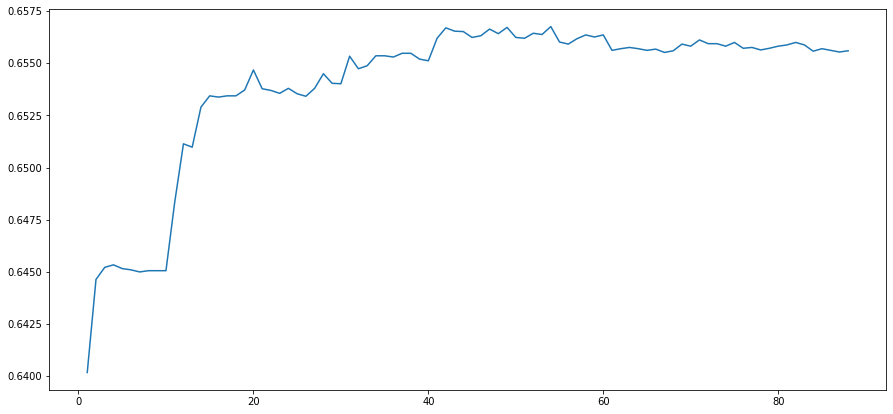

In [19]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(range(1, X.shape[1]+1), datos)
plt.show()

In [20]:
np.argmax(datos), datos[np.argmax(datos)]

(53, 0.6567599999999999)

In [23]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
rfe = RFE(model, np.argmax(datos))
fit = rfe.fit(X, y)
seleccion = X.columns[fit.support_]

In [24]:
seleccion

Index(['Average_Score', 'Total_Number_of_Reviews_Reviewer_Has_Given',
       'room_Neg_Hotel', 'facilities_Neg_Hotel', 'staff_Pos_Hotel',
       'comfort_Pos_Hotel', 'mean', 'std', 'max', 'Review_Month_1',
       'Review_Month_10', 'Review_Month_12', 'Review_Month_2',
       'Review_Month_3', 'Review_Month_4', 'Review_Month_6', 'Review_Month_7',
       'Review_Month_8', 'Review_Month_9', 'City_Amsterdam', 'City_Barcelona',
       'City_London', 'City_Paris', 'Pet_With a pet', 'Purpose_Business trip',
       'Purpose_Leisure trip', 'Whom_Couple',
       'Whom_Family with older children', 'Whom_Family with young children',
       'Whom_Solo traveler', 'Whom_Travelers with friends',
       'Room_Recode_Deluxe', 'Room_Recode_Executive',
       'Room_Recode_Other (Standard)', 'Room_Recode_Studio',
       'Room_Recode_Suite', 'Nationality_Recode_Arab States',
       'Nationality_Recode_Asia & Pacific',
       'Nationality_Recode_Eastern Europe', 'Nationality_Recode_Middle east',
       'Nati

In [26]:
[i for i in X.columns if i not in seleccion]

['Close_Landmarks',
 'Dist_Center',
 'Dist_Train',
 'Dist_Airport',
 'food_Neg_Hotel',
 'staff_Neg_Hotel',
 'location_Neg_Hotel',
 'value_Neg_Hotel',
 'comfort_Neg_Hotel',
 'cleanliness_Neg_Hotel',
 'food_Pos_Hotel',
 'location_Pos_Hotel',
 'value_Pos_Hotel',
 'room_Pos_Hotel',
 'facilities_Pos_Hotel',
 'cleanliness_Pos_Hotel',
 'Price',
 'Reservation_ADR',
 'count',
 'min',
 '25%',
 '50%',
 '75%',
 'Review_Month_11',
 'Review_Month_5',
 'City_Milan',
 'City_Vienna',
 'Whom_Group',
 'Nationality_Recode_China',
 'Length_Recode_Stayed 1 night',
 'Length_Recode_Stayed 3 nights',
 'Length_Recode_Stayed 4 nights',
 'Length_Recode_Stayed 5 nights',
 'Stars_hotel de 4 estrellas',
 'Stars_hotel de 5 estrellas']